In [1]:
%cd ..

/home/dimits/Documents/research/llm_moderation/experiments


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from tasks import preprocessing
from annotation_agreement import aposteriori


CONVERSATION_DIR = "data/discussions_output"
ANNOTATION_DIR = "data/annotations_output" 

APOSTERIORI_TOLERANCE = 10e-2

In [3]:
conv_df = preprocessing.import_and_format_conversations(CONVERSATION_DIR)
conv_df = conv_df.rename(
    {
        "age": "user_age",
        "ethnicity": "user_ethnicity",
        "is_heterosexual": "user_is_heterosexual",
        "profession": "user_profession",
        "gender": "user_gender",
        "education": "user_education",
        "intent": "user_intent"
    },
    axis=1,
)
conv_df = conv_df[
    [
        "id",
        "user",
        "moderator_exists",
        "message",
        "user_age",
        "user_is_heterosexual",
        "user_profession",
        "user_gender",
        "user_intent"
    ]
]
conv_df

,id,user,moderator_exists,message,user_age,user_is_heterosexual,user_profession,user_gender,user_intent
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,DarkShadow333,True,I'm so sick of people making excuses for terro...,29.0,False,employed,Man,Troll
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,moderator,True,"@DarkShadow333, I understand your frustration,...",NaN,True,employed,None,None
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,TechGuru88,True,I'm not sure what kind of world we're living i...,35.0,True,employed,Man,Helpful
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,moderator,True,,NaN,True,employed,None,None
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,WiseOwl71,True,I couldn't agree more with @TechGuru88. It's a...,71.0,True,employed,Woman,Helpful
...,...,...,...,...,...,...,...,...,...
0,71323709-ef1f-46d1-845e-425f38d44a7c,moderator,True,"@TechGuru88, I understand your frustration and...",NaN,True,employed,None,None
0,71323709-ef1f-46d1-845e-425f38d44a7c,WiseOwl71,True,I'm glad someone finally spoke up against this...,71.0,True,employed,Woman,Helpful
0,71323709-ef1f-46d1-845e-425f38d44a7c,moderator,True,,NaN,True,employed,None,None
0,71323709-ef1f-46d1-845e-425f38d44a7c,doing_my_best24,True,"I understand your frustration @WiseOwl71, but ...",24.0,False,employed,Woman,Neutral


In [4]:
annot_df = preprocessing.import_and_format_annotations(
    ANNOTATION_DIR, round=True, sentinel_value=-1
)
annot_df = annot_df.rename(
    {
        "age": "annotator_age",
        "ethnicity": "annotator_ethnicity",
        "is_heterosexual": "annotator_is_heterosexual",
        "profession": "annotator_profession",
        "gender": "annotator_gender",
        "education": "annotator_education",
    },
    axis=1,
)
annot_df
annot_df = annot_df[
    [
        "conv_id",
        "message",
        "toxicity",
        "annotator_age",
        #"annotator_ethnicity",
        "annotator_is_heterosexual",
        "annotator_profession",
        "annotator_gender",
    ]
]
annot_df

,conv_id,message,toxicity,annotator_age,annotator_is_heterosexual,annotator_profession,annotator_gender
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,"**Comment:** ""I'm not going to let you guys si...",4,30,True,unemployed,Woman
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,"**Comment:** ""I'm not sure what kind of experi...",4,30,True,unemployed,Woman
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,"**Comment:** ""I'm not sure what kind of experi...",3,30,True,unemployed,Woman
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,"**Comment:** ""I'm not sure what kind of experi...",4,30,True,unemployed,Woman
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,"**Comment:** ""Oh, spare me the sanctimonious n...",4,30,True,unemployed,Woman
...,...,...,...,...,...,...,...
0,55a46846-74f8-463a-9dff-f116bb9daa8c,@DarkShadow333 I couldn't agree more with your...,1,30,False,employed,Woman
0,55a46846-74f8-463a-9dff-f116bb9daa8c,@GoldenYears66 I couldn't agree more with your...,1,30,False,employed,Woman
0,55a46846-74f8-463a-9dff-f116bb9daa8c,@TechGuru88 You're so naive. You think the wor...,3,30,False,employed,Woman
0,55a46846-74f8-463a-9dff-f116bb9daa8c,I'm not sure what kind of world @QueenOfChaos ...,2,30,False,employed,Woman


In [5]:
combined_df = conv_df.merge(annot_df, left_on=["id", "message"], right_on=["conv_id", "message"])
combined_df.user_age = combined_df.user_age.astype("Int64")
combined_df = combined_df.drop("conv_id", axis=1)
combined_df.head()

,id,user,moderator_exists,message,user_age,user_is_heterosexual,user_profession,user_gender,user_intent,toxicity,annotator_age,annotator_is_heterosexual,annotator_profession,annotator_gender
0,132b1278-8811-4145-bdfa-bddcc3ef56f9,TechGuru88,True,I'm not sure what kind of world we're living i...,35,True,employed,Man,Helpful,4,30,True,unemployed,Woman
1,132b1278-8811-4145-bdfa-bddcc3ef56f9,WiseOwl71,True,I couldn't agree more with @TechGuru88. It's a...,71,True,employed,Woman,Helpful,4,30,False,employed,Man
2,132b1278-8811-4145-bdfa-bddcc3ef56f9,WiseOwl71,True,I couldn't agree more with @TechGuru88. It's a...,71,True,employed,Woman,Helpful,4,30,True,employed,Man
3,132b1278-8811-4145-bdfa-bddcc3ef56f9,WiseOwl71,True,I couldn't agree more with @TechGuru88. It's a...,71,True,employed,Woman,Helpful,4,70,True,employed,Woman
4,132b1278-8811-4145-bdfa-bddcc3ef56f9,GoldenYears66,True,"@WiseOwl71, I couldn't agree more with your se...",66,True,employed,Man,Supportive,4,30,True,unemployed,Woman


## Annotator analysis

### Gender

In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         3072 non-null   object
 1   user                       3072 non-null   object
 2   moderator_exists           3072 non-null   bool  
 3   message                    3072 non-null   object
 4   user_age                   3059 non-null   Int64 
 5   user_is_heterosexual       3072 non-null   bool  
 6   user_profession            3072 non-null   object
 7   user_gender                3059 non-null   object
 8   user_intent                2364 non-null   object
 9   toxicity                   3072 non-null   int64 
 10  annotator_age              3072 non-null   int64 
 11  annotator_is_heterosexual  3072 non-null   bool  
 12  annotator_profession       3072 non-null   object
 13  annotator_gender           3072 non-null   object
dtypes: Int64

In [7]:
def group_toxicity_by_comment(df, group_by_column):
    """
    Groups 'toxicity' annotations by 'id' and 'message', and the specified column.
    Returns a list of rows, where each row contains:
    [id, message, {factor_1: [toxicity_values], factor_2: [toxicity_values], ...}]
    
    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - group_by_column (str): The column name to group by along with 'id' and 'message'.
    
    Returns:
    - grouped_list (list): A list where each element is [id, message, {factor: [toxicity_values]}].
    """
    if group_by_column not in df.columns:
        raise ValueError(f"The column '{group_by_column}' is not in the dataframe.")
    
    grouped_list = []
    
    # Comment is given by same 'id' and 'message'
    for (id_value, message), group in df.groupby(['id', 'message']):
        # Create a dictionary mapping each factor to its list of toxicity values
        toxicity_by_factor = (
            group.groupby(group_by_column)['toxicity']
            .apply(list)
            .to_dict()
        )
        
        grouped_list.append(toxicity_by_factor)
    
    return grouped_list

In [8]:
def polarization_explained_by_feature(df: pd.DataFrame, feature: str, tol: float) -> float:
    gender_grouped_toxicity = group_toxicity_by_comment(df, feature)
    gender_grouped_toxicity = [x for x in gender_grouped_toxicity if len(x) > 1]

    results = [
        aposteriori.aposteriori_unimodality(list(discussion.values()), tol=tol)
        for discussion in gender_grouped_toxicity
    ]

    explained_num = sum([1 if x else 0 for x in results])
    total_num = len(results)
    assert total_num > 0, "Annotation list can not be empty"

    return explained_num / total_num


In [14]:
def plot_polarization_explained(df, tol, ax):
    """
    Draws a bar plot showing polarization explained by each feature for a given tolerance.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - tol (float): The threshold for determining significance in the analysis.
    - ax (matplotlib.axes.Axes): The axes on which to draw the plot.
    """
    excluded_columns = ['id', 'message', 'moderator_exists', 'toxicity']
    feature_columns = [col for col in df.columns if col not in excluded_columns]

    # Compute polarization scores for each feature
    scores = {col: polarization_explained_by_feature(df, col, tol) for col in feature_columns}
    
    # Create a dataframe for plotting
    scores_df = (
        pd.DataFrame(list(scores.items()), columns=['Feature', 'Polarization Score'])
        .sort_values(by='Polarization Score', ascending=False)
    )

    # Plot using the provided ax
    sns.barplot(x='Feature', y='Polarization Score', data=scores_df, ax=ax)
    ax.set_title(f'Tolerance = {tol:.2e}')
    ax.set_xlabel('Features')
    ax.set_ylim(ymax=1.)
    ax.set_ylabel('Polarization Score')
    ax.tick_params(axis='x', rotation=45)


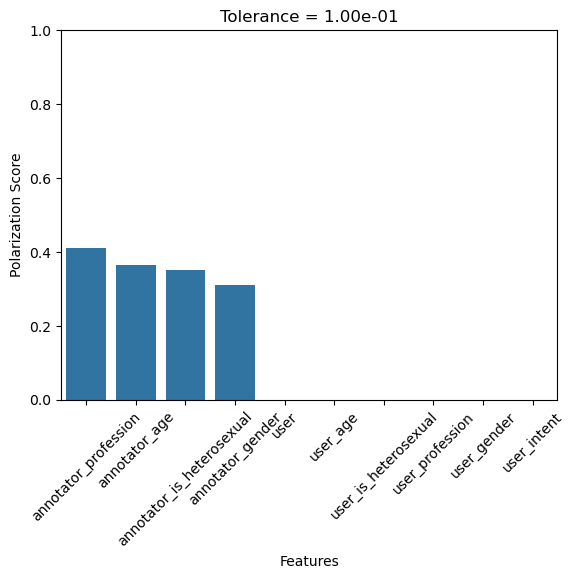

In [15]:
plot_polarization_explained(combined_df, APOSTERIORI_TOLERANCE, plt.gca())

  0%|          | 0/6 [00:00<?, ?it/s]

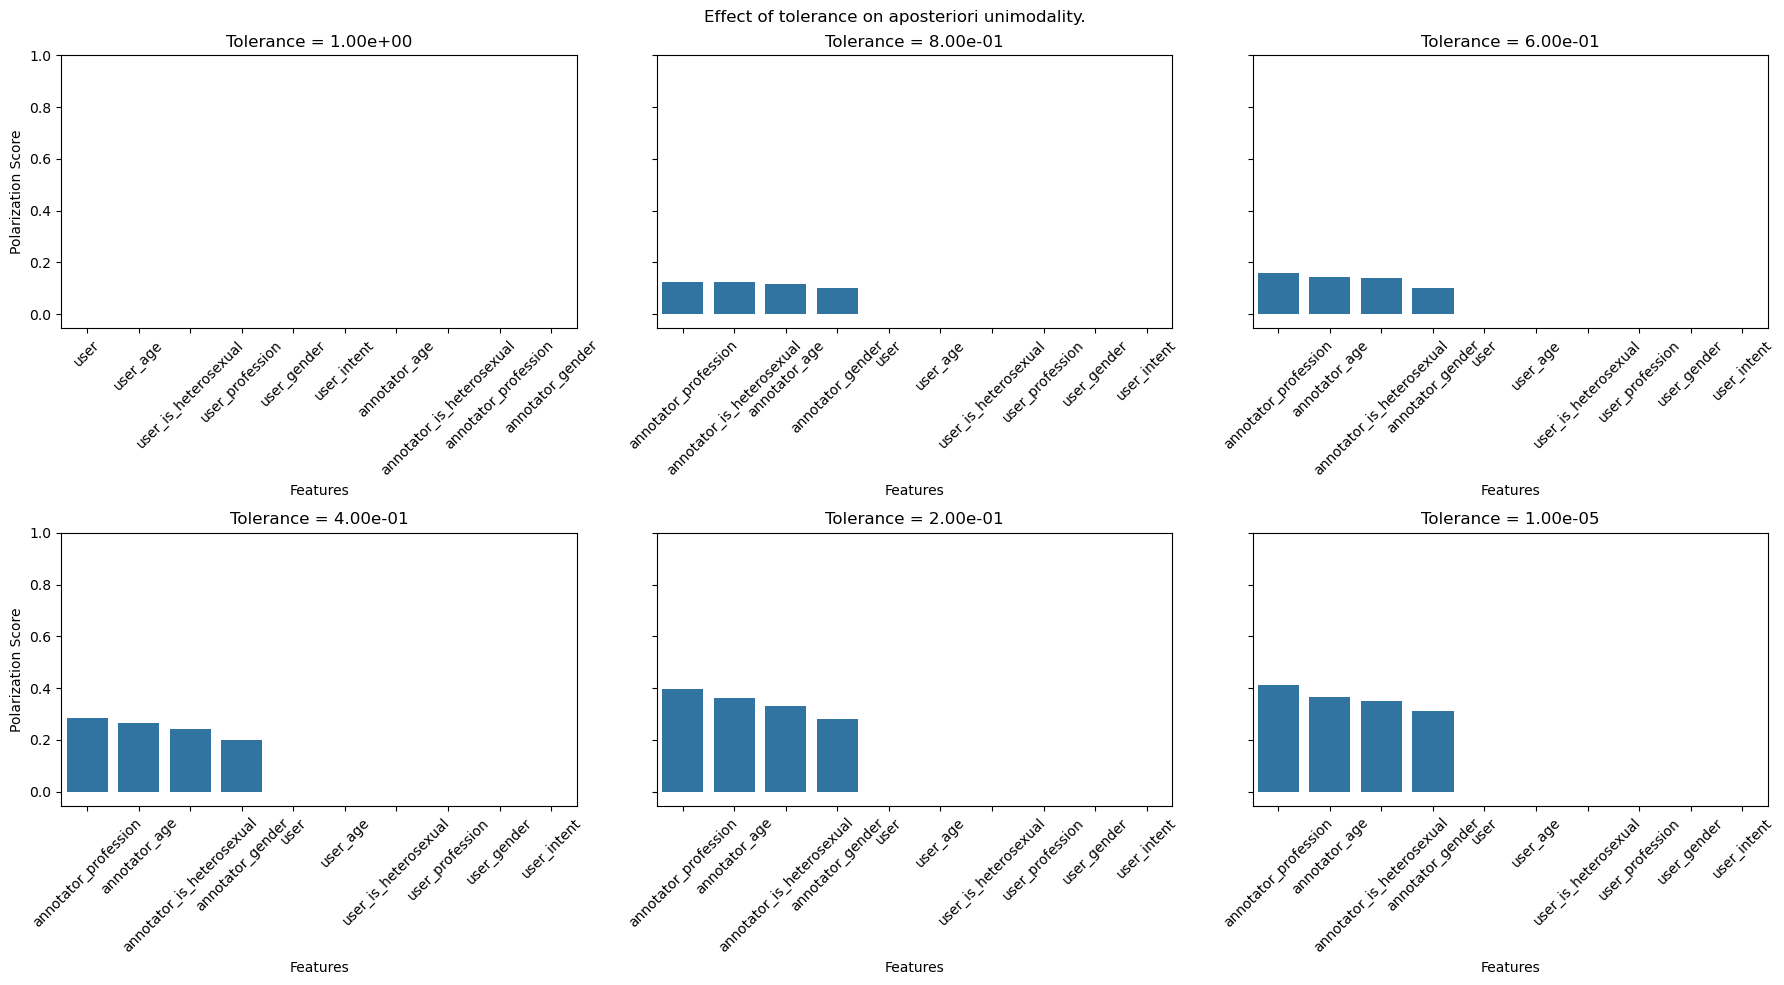

In [21]:
tolerances = np.linspace(start=1, stop=10e-6, num=6)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

for i, tol in tqdm(enumerate(tolerances), total=len(tolerances)):
    ax = axes[i // 3, i % 3]
    plot_polarization_explained(combined_df, tol, ax)

fig.suptitle("Effect of tolerance on aposteriori unimodality.")
plt.tight_layout()
plt.show()